In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVR
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import RobustScaler
from sklearn.datasets import load_diabetes
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor
from mlxtend.regressor import StackingCVRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Ridge, HuberRegressor, LinearRegression
from scipy.stats import skew, norm, probplot
from sklearn.feature_selection import mutual_info_regression
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans

filepath = '../input/house-prices-advanced-regression-techniques/train.csv'
testfilepath = '../input/house-prices-advanced-regression-techniques/test.csv'

train_data = pd.read_csv(filepath)
test_data = pd.read_csv(testfilepath)
full_data = pd.concat([train_data,test_data], axis = 0).reset_index(drop=True)

full_data = full_data.drop('Id',axis = 1).drop('SalePrice',axis = 1)
full_data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


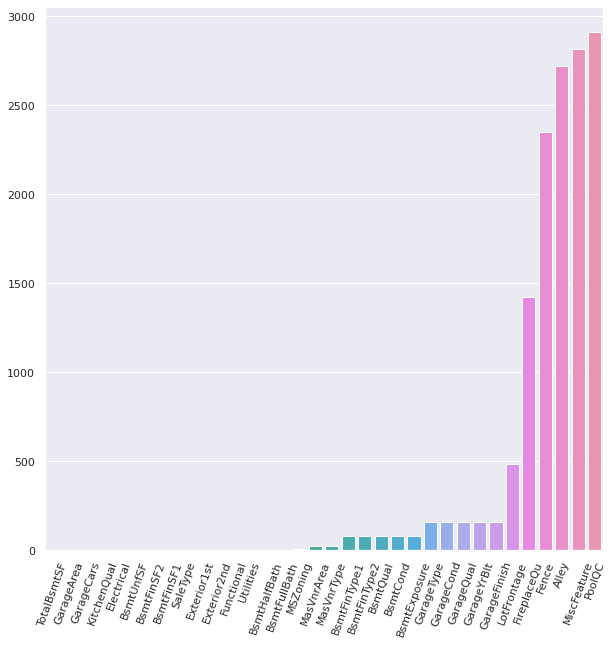

In [2]:
sns.set(rc={"figure.figsize":(10, 10)})
missing = full_data.isnull().sum()
missing = missing[missing > 0]
missing = missing.sort_values()
sns.barplot(x=missing.index, y=[missing[i] for i in range(len(missing))])
plt.xticks(rotation = 70)
plt.show()

**Step 1. Impute the missing data**

In [3]:
None_cols = ['PoolQC','MiscFeature','Alley','Fence','FireplaceQu','GarageFinish','GarageQual','GarageCond','GarageType','BsmtCond','BsmtExposure',
             'BsmtQual','BsmtFinType1','BsmtFinType2','MasVnrType']
Zero_cols = ['GarageYrBlt', 'MasVnrArea', 'BsmtHalfBath', 'BsmtFullBath', 'BsmtFinSF1', 'BsmtFinSF2', 'TotalBsmtSF', 'BsmtUnfSF']
for noncols in None_cols:
    full_data[noncols] = full_data[noncols].fillna("None")
for zerocols in Zero_cols:
    full_data[zerocols] = full_data[zerocols].fillna(0)
full_data['Functional'] = full_data['Functional'].fillna('Typ')
full_data['Utilities'] = full_data['Utilities'].fillna('AllPub')
full_data['SaleType'] = full_data['SaleType'].fillna('WD')
full_data['Electrical'] = full_data['Electrical'].fillna('SBrkr')
full_data['KitchenQual'] = full_data['KitchenQual'].fillna('TA')
full_data['Exterior1st'] = full_data['Exterior1st'].fillna('VinylSd')
full_data['Exterior2nd'] = full_data['Exterior2nd'].fillna('VinylSd')
Gtype_group = full_data.groupby(full_data['GarageType']).mean()
full_data['GarageArea'] = full_data['GarageArea'].fillna(Gtype_group.loc['Detchd','GarageArea'])
full_data['GarageCars'] = full_data['GarageCars'].fillna(2)
print([full_data[noncols].isnull().sum() for noncols in None_cols])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


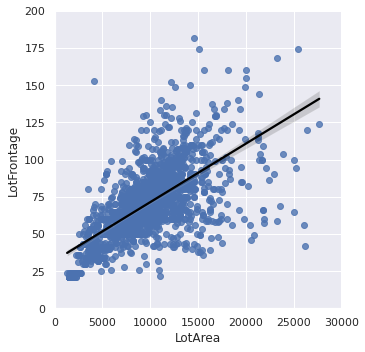

In [4]:
#print(full_data.columns)
full_data_Lot = full_data.loc[:,['LotFrontage','LotArea']]
full_data_Lot = full_data_Lot[(~full_data_Lot['LotFrontage'].isnull()) & (full_data_Lot['LotFrontage']<=200) & (full_data_Lot['LotArea']<=30000)]
lotplot = sns.lmplot(data=full_data_Lot, x='LotArea', y='LotFrontage', line_kws={'color': 'black'})
lotplot = (lotplot.set(xlim=(0,30000),ylim=(0,200)))
plt.show()

In [5]:
method = LinearRegression()
method.fit(full_data_Lot.loc[:,'LotArea'].values.reshape(-1, 1),full_data_Lot.loc[:,'LotFrontage'].values)
lot_null_list = full_data.loc[full_data['LotFrontage'].isnull()==True]
lot_null_lotarea_values = lot_null_list.loc[:,'LotArea'].reset_index(drop=True).values
lot_null_lotarea_index = lot_null_list.loc[:,'LotArea'].index
lot_app_data = method.predict(lot_null_lotarea_values.reshape(-1, 1)).tolist()
full_data_Lot_null = full_data.loc[full_data['LotFrontage'].isnull()==True]
full_data_Lot_null_list = full_data_Lot_null.index.tolist() 
for i in range(len(lot_app_data)):
    full_data['LotFrontage'][full_data_Lot_null_list[i]] = lot_app_data[i]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


     MSZoning Neighborhood
1915      NaN       IDOTRR
2216      NaN       IDOTRR
2250      NaN       IDOTRR
2904      NaN      Mitchel


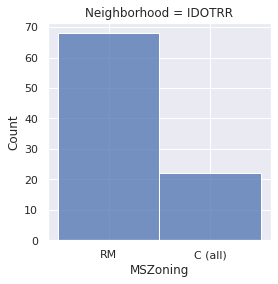

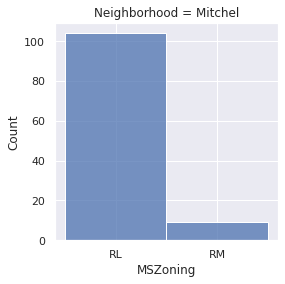

In [6]:
data_ms_nei = full_data.loc[:,['MSZoning','Neighborhood']]
print(data_ms_nei.loc[data_ms_nei['MSZoning'].isnull()==True])
data_nei_ido = data_ms_nei.loc[data_ms_nei['Neighborhood']=='IDOTRR']
data_nei_mit = data_ms_nei.loc[data_ms_nei['Neighborhood']=='Mitchel']
sns.set(rc={"figure.figsize":(4, 4)})
sns.histplot(data = data_nei_ido, x = 'MSZoning')
plt.title("Neighborhood = IDOTRR")
plt.show()
sns.histplot(data = data_nei_mit, x = 'MSZoning')
plt.title("Neighborhood = Mitchel")
plt.show()
full_data.loc[(full_data['MSZoning'].isnull()==True) & (full_data['Neighborhood']=='IDOTRR'), 'MSZoning'] = 'RM'
full_data.loc[(full_data['MSZoning'].isnull()==True) & (full_data['Neighborhood']=='Mitchel'), 'MSZoning'] = 'RL'

**Step 2. Feature transformation**

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


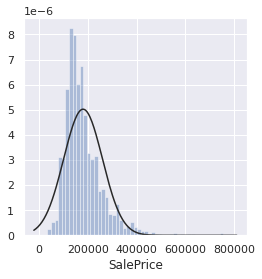

((array([-3.30513952, -3.04793228, -2.90489705, ...,  2.90489705,
          3.04793228,  3.30513952]),
  array([ 34900,  35311,  37900, ..., 625000, 745000, 755000])),
 (74160.16474519414, 180921.19589041095, 0.9319665641512983))

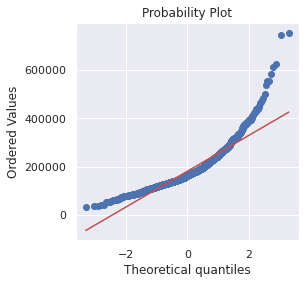

In [7]:
y = train_data['SalePrice']
sns.distplot(y, kde=False, fit = stats.norm)
plt.show()
probplot(y, plot=plt)

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


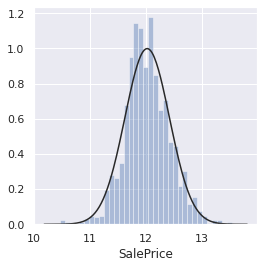

((array([-3.30513952, -3.04793228, -2.90489705, ...,  2.90489705,
          3.04793228,  3.30513952]),
  array([10.46024211, 10.47194981, 10.54270639, ..., 13.34550693,
         13.5211395 , 13.53447303])),
 (0.3982622308161888, 12.024050901109383, 0.9953761475636613))

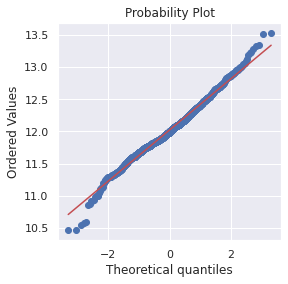

In [8]:
y = np.log(y)
sns.distplot(y, kde=False, fit = stats.norm)
plt.show()
probplot(y, plot=plt)

**Step 3. Feature encoding**

In [9]:
total_cols = full_data.columns.tolist()
cat_cols = [cols for cols in total_cols if full_data[cols].dtype == 'object']
num_cols = [cols for cols in total_cols if full_data[cols].dtype != 'object']

In [10]:
full_data['Street'] = full_data['Street'].replace({'Grvl':0, 'Pave':1})
full_data['Alley'] = full_data['Alley'].replace({'None':0, 'Grvl':1, 'Pave':2})
full_data['LotShape'] = full_data['LotShape'].replace({'Reg':0, 'IR1':1, 'IR2':2, 'IR3':3})
full_data['LandSlope'] = full_data['LandSlope'].replace({'Gtl':0, 'Mod':1, 'Sev':2})
full_data['ExterQual'] = full_data['ExterQual'].replace({'Po':0, 'Fa':1, 'TA':2, 'Gd':3, 'Ex':4})
full_data['ExterCond'] = full_data['ExterCond'].replace({'Po':0, 'Fa':1, 'TA':2, 'Gd':3, 'Ex':4})
full_data['BsmtQual'] = full_data['BsmtQual'].replace({'None':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
full_data['BsmtCond'] = full_data['BsmtCond'].replace({'None':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
full_data['BsmtExposure'] = full_data['BsmtExposure'].replace({'None':0, 'No':1, 'Mn':2, 'Av':3, 'Gd':4})
full_data['BsmtFinType1'] = full_data['BsmtFinType1'].replace({'None':0, 'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6})
full_data['BsmtFinType2'] = full_data['BsmtFinType2'].replace({'None':0, 'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6})
full_data['HeatingQC'] = full_data['HeatingQC'].replace({'Po':0, 'Fa':1, 'TA':2, 'Gd':3, 'Ex':4})
full_data['CentralAir'] = full_data['CentralAir'].replace({'N':0, 'Y':1})
full_data['KitchenQual'] = full_data['KitchenQual'].replace({'Po':0, 'Fa':1, 'TA':2, 'Gd':3, 'Ex':4})
full_data['Functional'] = full_data['Functional'].replace({'Sal':0, 'Sev':1, 'Maj2':2, 'Maj1':3, 'Mod':4, 'Min2':5, 'Min1':6, 'Typ':7})
full_data['FireplaceQu'] = full_data['FireplaceQu'].replace({'None':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
full_data['GarageFinish'] = full_data['GarageFinish'].replace({'None':0, 'Unf':1, 'RFn':2, 'Fin':3})
full_data['GarageQual'] = full_data['GarageQual'].replace({'None':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
full_data['GarageCond'] = full_data['GarageCond'].replace({'None':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
full_data['PavedDrive'] = full_data['PavedDrive'].replace({'N':0, 'P':1, 'Y':2})
full_data['PoolQC'] = full_data['PoolQC'].replace({'None':0, 'Fa':1, 'TA':2, 'Gd':3, 'Ex':4})
full_data['Fence'] = full_data['Fence'].replace({'None':0, 'MnWw':1, 'GdWo':2, 'MnPrv':3, 'GdPrv':4})
cat_list = [1,2,3,7,18,19,21,22,23,24,25,27,28,30,31,32,34,35,36,37,38,39]
cat_to_num_list = [cat_cols[i] for i in cat_list]
cat_cols = [cat_cols[i] for i in range(len(cat_cols)) if i not in cat_list]

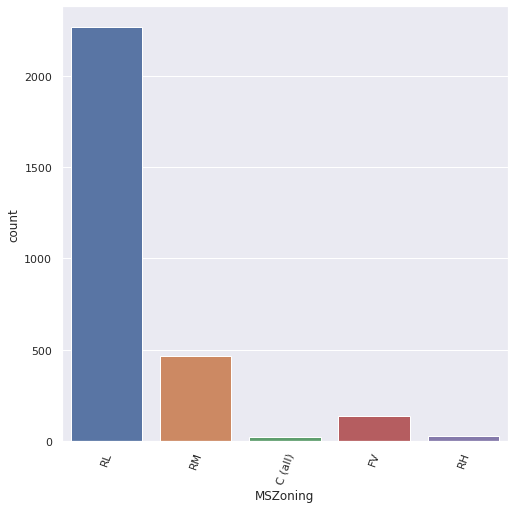

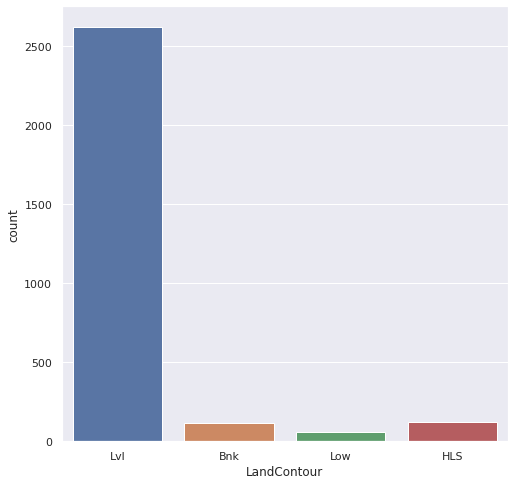

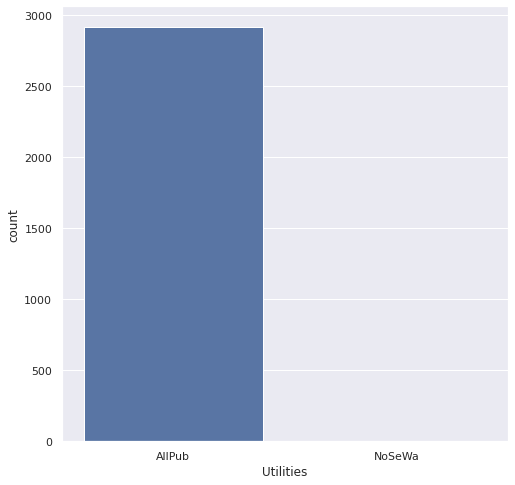

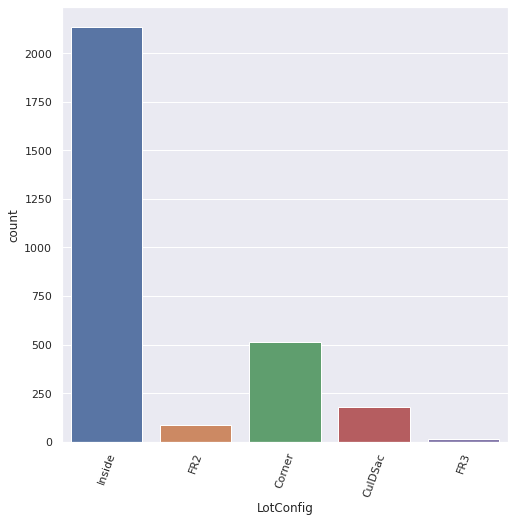

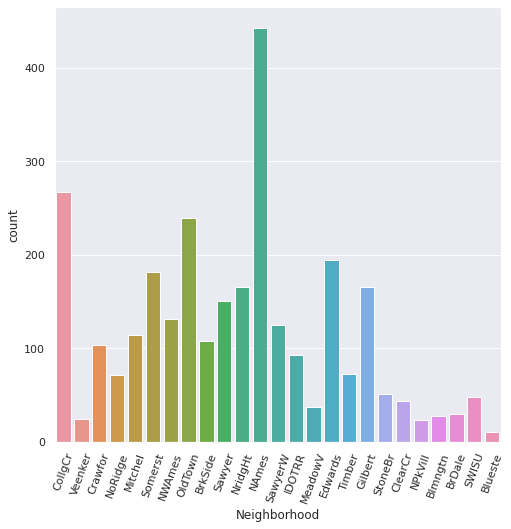

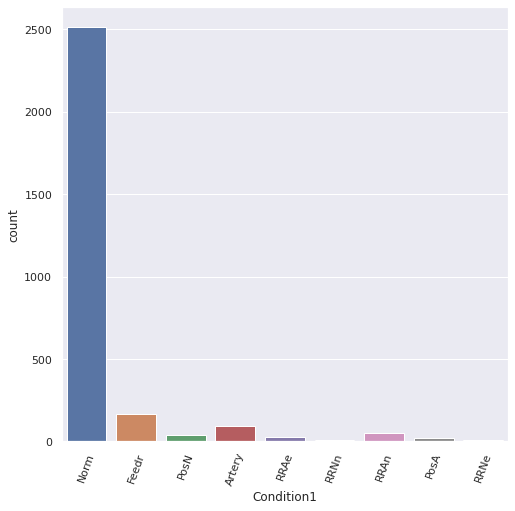

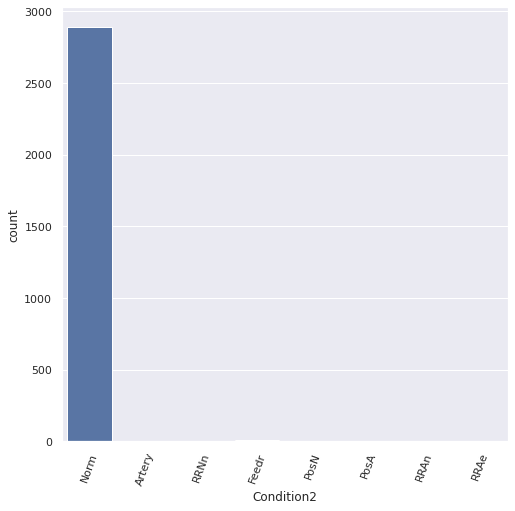

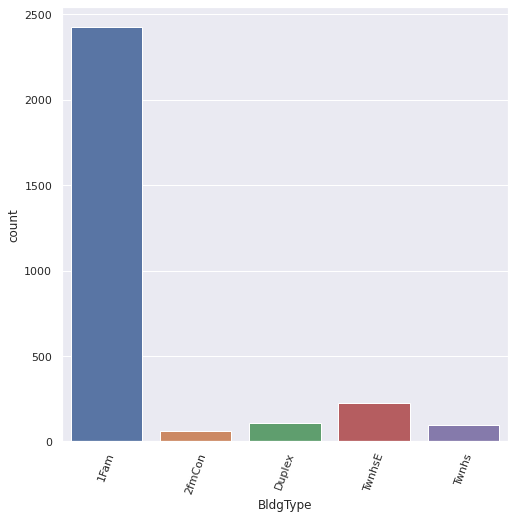

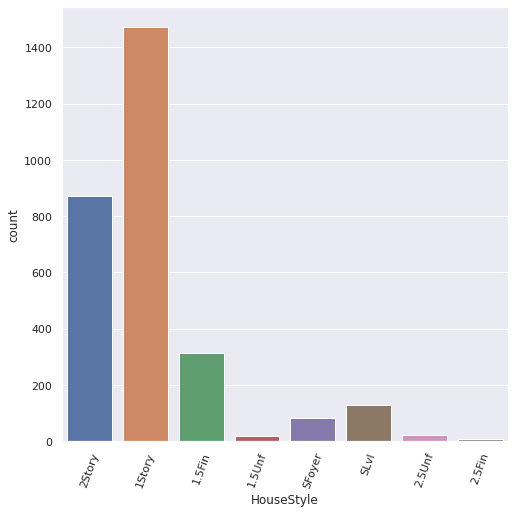

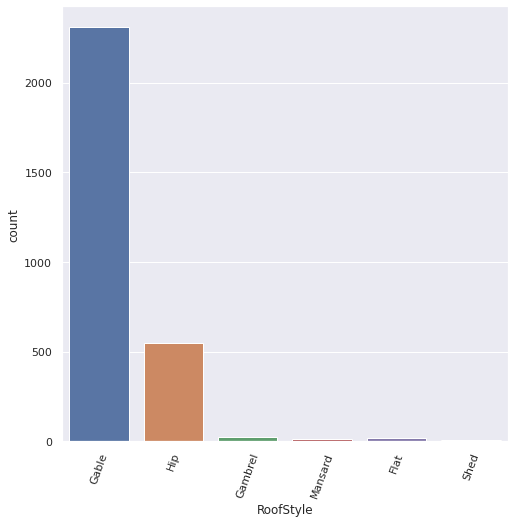

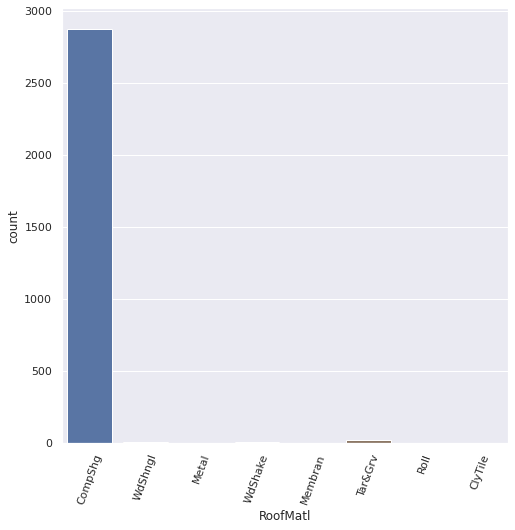

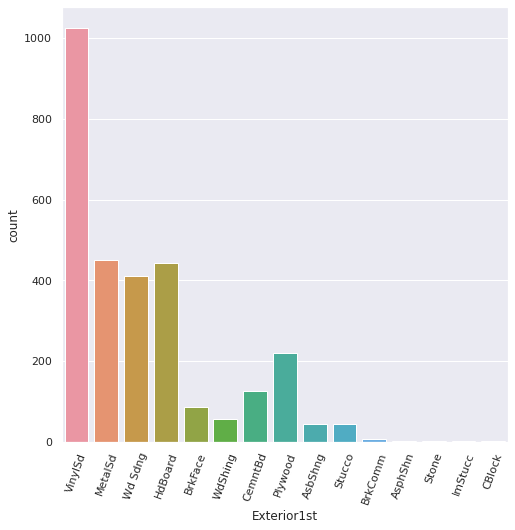

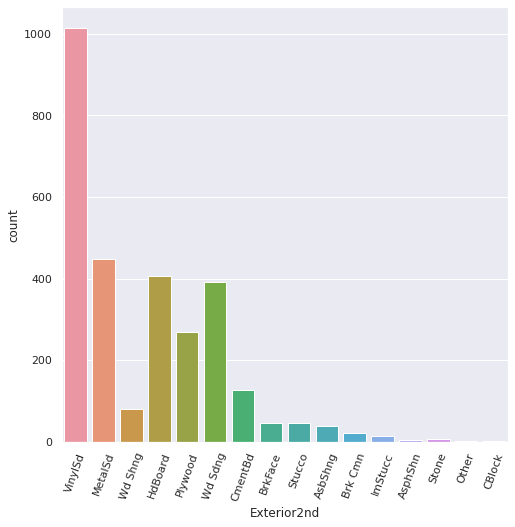

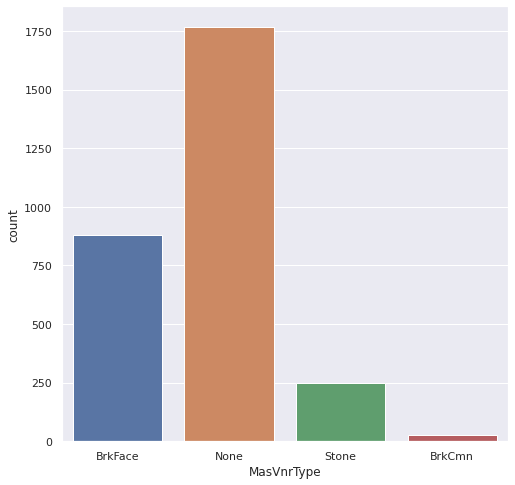

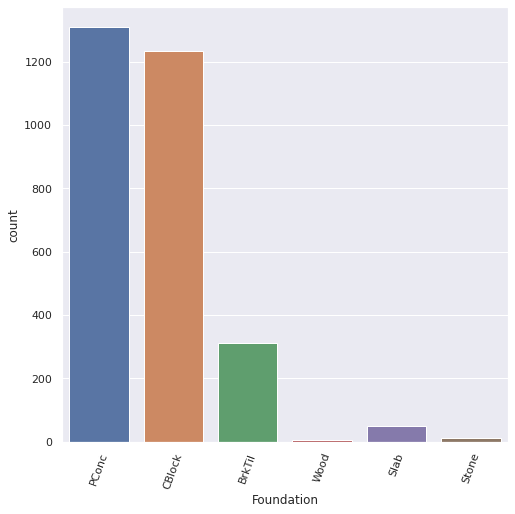

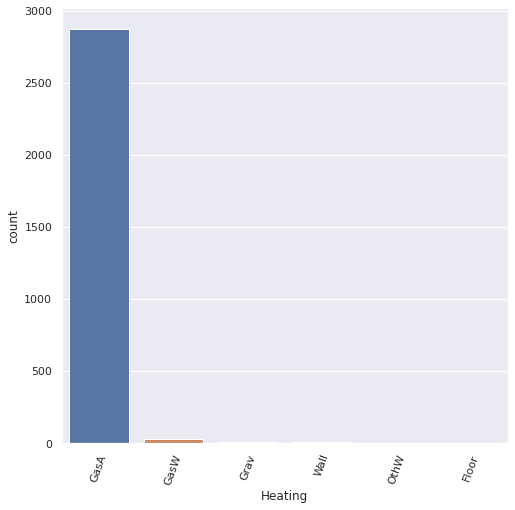

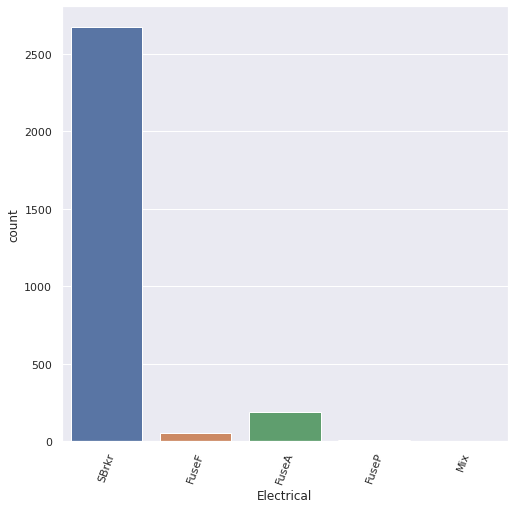

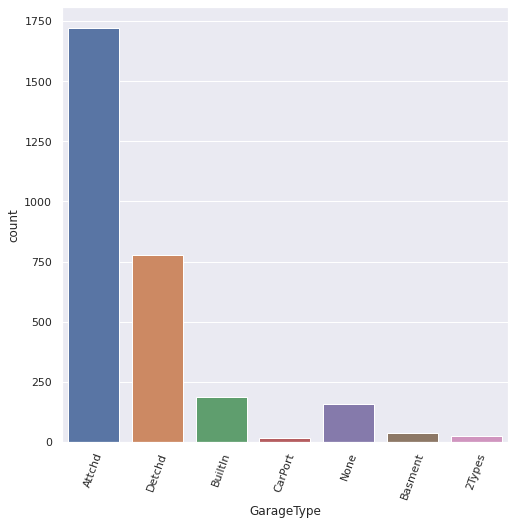

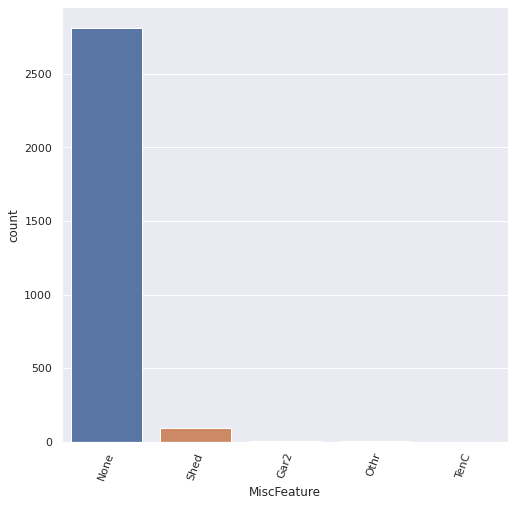

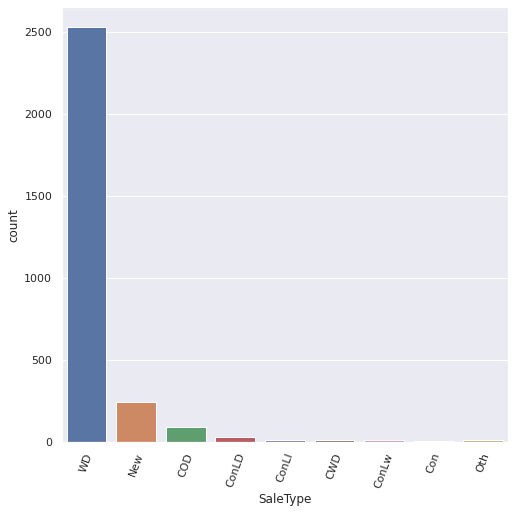

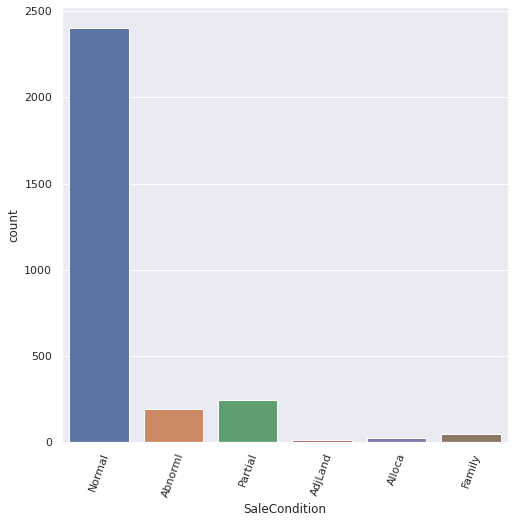

In [11]:
sns.set(rc={"figure.figsize":(8, 8)})
for cols in cat_cols:
    sns.countplot(data = full_data, x = cols)
    if full_data[cols].nunique()>=5:
        plt.xticks(rotation = 70)
    plt.show()

In [12]:
full_data['MSZoning'] = pd.Series(['Others' if x not in ['RM','RL','FV'] else x for x in full_data['MSZoning'].values.tolist()])
full_data['LandContour'] =pd.Series([0 if x not in ['Lvl'] else 1 for x in full_data['LandContour'].values.tolist()])
full_data['Utilities'] =pd.Series([0 if x not in ['AllPub'] else 1 for x in full_data['Utilities'].values.tolist()])
full_data['LotConfig'] =pd.Series(['Others' if x not in ['Inside','Corner','CulDSac'] else x for x in full_data['LotConfig'].values.tolist()])
full_data['Condition1'] =pd.Series([0 if x not in ['Norm'] else 1 for x in full_data['Condition1'].values.tolist()])
full_data['Condition2'] =pd.Series([0 if x not in ['Norm'] else 1 for x in full_data['Condition2'].values.tolist()])
full_data['BldgType'] =pd.Series(['Others' if x not in ['1Fam','TwnhsE'] else x for x in full_data['BldgType'].values.tolist()])
full_data['RoofStyle'] =pd.Series(['Others' if x not in ['Gable','Hip'] else x for x in full_data['RoofStyle'].values.tolist()])
full_data['RoofMatl'] =pd.Series([0 if x not in ['CompShg'] else 1 for x in full_data['RoofMatl'].values.tolist()])
full_data['Exterior1st'] =pd.Series(['Others' if x in ['AsphShn','BrkComm','CBlock','ImStucc','Stone'] else x for x in full_data['Exterior1st'].values.tolist()])
full_data['Exterior2nd'] =pd.Series(['Others' if x in ['AsphShn','BrkComm','CBlock','ImStucc','Stone'] else x for x in full_data['Exterior2nd'].values.tolist()])
full_data['Foundation'] =pd.Series(['Others' if x not in ['PConc','CBlock','BrkTil'] else x for x in full_data['Foundation'].values.tolist()])
full_data['Heating'] =pd.Series([0 if x not in ['GasA'] else 1 for x in full_data['Heating'].values.tolist()])
full_data['Electrical'] =pd.Series([0 if x not in ['SBrkr'] else 1 for x in full_data['Electrical'].values.tolist()])
full_data['GarageType'] =pd.Series(['Others' if x not in ['Attchd','Detchd','BuiltIn'] else x for x in full_data['GarageType'].values.tolist()])
full_data['MiscFeature'] =pd.Series([0 if x not in ['None'] else 1 for x in full_data['MiscFeature'].values.tolist()])
full_data['SaleType'] =pd.Series(['Others' if x not in ['WD','New','COD'] else x for x in full_data['SaleType'].values.tolist()])
full_data['SaleCondition'] =pd.Series(['Others' if x not in ['Normal','Abnorml','Partial'] else x for x in full_data['SaleCondition'].values.tolist()])
cat_to_num_list2 = ['LandContour','Utilities','Condition1','Condition2','RoofMatl','Heating','Electrical','MiscFeature']
cat_cols = [cols for cols in cat_cols if cols not in cat_to_num_list2]

In [13]:
"""
y = train_data['SalePrice']
full_data_train1 = full_data.loc[:len(train_data)-1]
full_data_test1 = full_data.loc[len(train_data):]
full_data_with_SP=pd.concat([full_data_train1,y],axis = 1)

neighborhood = full_data_with_SP.groupby(['Neighborhood'])['SalePrice'].describe()
display(neighborhood.head())

neighborhood_cluster = KMeans(n_clusters=5, random_state = 927)
neighborhood_cluster.fit(neighborhood)

neigh_cluster_table = pd.DataFrame(zip(list(neighborhood.index),list(neighborhood.loc[:,'mean']),list(neighborhood_cluster.labels_)),columns = ['Neighborhood','MeanSalePrice','Neighborhood Cluster'])
for i  in range(len(neigh_cluster_table.groupby('Neighborhood Cluster')['Neighborhood'].unique())):
    print("Cluster " + str(i))
    print(neigh_cluster_table.groupby('Neighborhood Cluster')['Neighborhood'].unique()[i])
sns.scatterplot(data = neigh_cluster_table, x='Neighborhood',y = 'MeanSalePrice', hue='Neighborhood Cluster',palette=sns.color_palette("Set2",5))
plt.xticks(rotation=70)
plt.show()

subclass = full_data_with_SP.groupby(['MSSubClass'])['SalePrice'].describe()
display(subclass.head())

subclass_cluster = KMeans(n_clusters=4, random_state = 927)
subclass_cluster.fit(subclass)

mssub_cluster_table = pd.DataFrame(zip(list(subclass.index),list(subclass.loc[:,'mean']),list(subclass_cluster.labels_)),columns = ['MSSubClass','MeanSalePrice','MSSubClass Cluster'])
for i  in range(len(mssub_cluster_table.groupby('MSSubClass Cluster')['MSSubClass'].unique())):
    print("Cluster " + str(i))
    print(mssub_cluster_table.groupby('MSSubClass Cluster')['MSSubClass'].unique()[i])
sns.scatterplot(data = mssub_cluster_table, x='MSSubClass',y = 'MeanSalePrice', hue='MSSubClass Cluster',palette=sns.color_palette("Set2",4))
plt.xticks(rotation=70)
plt.show()

mssub_cluster_table.drop('MeanSalePrice', axis = 1 ,inplace = True)
neigh_cluster_table.drop('MeanSalePrice', axis = 1, inplace = True)

full_data_train1=pd.merge(left = full_data_train1.reset_index(drop=True), right = mssub_cluster_table, how='left', on ='MSSubClass')
full_data_train1=pd.merge(left = full_data_train1.reset_index(drop=True), right = neigh_cluster_table, how='left', on ='Neighborhood')

full_data_train1.drop('MSSubClass', axis = 1 ,inplace = True)
full_data_train1.drop('Neighborhood', axis = 1 ,inplace = True)

full_data_test1 = pd.merge(left = full_data_test1.reset_index(drop=True), right = mssub_cluster_table, how='left', on ='MSSubClass')
full_data_test1 = pd.merge(left = full_data_test1.reset_index(drop=True), right = neigh_cluster_table, how='left', on ='Neighborhood')
full_data_test1.drop('MSSubClass', axis = 1 ,inplace = True)
full_data_test1.drop('Neighborhood', axis = 1 ,inplace = True)

cat_cols.remove('Neighborhood')
num_cols.remove('MSSubClass')
cat_to_num_list2.append('MSSubClass Cluster')
cat_to_num_list2.append('Neighborhood Cluster')

full_data = pd.concat([full_data_train1,full_data_test1], axis = 0).reset_index(drop=True)
"""

'\ny = train_data[\'SalePrice\']\nfull_data_train1 = full_data.loc[:len(train_data)-1]\nfull_data_test1 = full_data.loc[len(train_data):]\nfull_data_with_SP=pd.concat([full_data_train1,y],axis = 1)\n\nneighborhood = full_data_with_SP.groupby([\'Neighborhood\'])[\'SalePrice\'].describe()\ndisplay(neighborhood.head())\n\nneighborhood_cluster = KMeans(n_clusters=5, random_state = 927)\nneighborhood_cluster.fit(neighborhood)\n\nneigh_cluster_table = pd.DataFrame(zip(list(neighborhood.index),list(neighborhood.loc[:,\'mean\']),list(neighborhood_cluster.labels_)),columns = [\'Neighborhood\',\'MeanSalePrice\',\'Neighborhood Cluster\'])\nfor i  in range(len(neigh_cluster_table.groupby(\'Neighborhood Cluster\')[\'Neighborhood\'].unique())):\n    print("Cluster " + str(i))\n    print(neigh_cluster_table.groupby(\'Neighborhood Cluster\')[\'Neighborhood\'].unique()[i])\nsns.scatterplot(data = neigh_cluster_table, x=\'Neighborhood\',y = \'MeanSalePrice\', hue=\'Neighborhood Cluster\',palette=sns.col

In [14]:
OH_encoder = OneHotEncoder(handle_unknown = 'ignore', sparse = False)
OH_cols = pd.DataFrame(OH_encoder.fit_transform(full_data[cat_cols]))
OH_cols.index = full_data.index
OH_cols.columns = OH_encoder.get_feature_names(cat_cols)
full_data = full_data.drop(cat_cols,axis = 1)
full_data = pd.concat([full_data, OH_cols], axis = 1)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


**Step 4. Feature Transformation**

In [15]:
skewed = full_data[num_cols].apply(lambda x: skew(x.dropna().astype(float)))
skewed = skewed[abs(skewed) > 0.5]
skewed = skewed.index

full_data[skewed]=np.log1p(full_data[skewed])

scaler = RobustScaler()
full_data_rescaled = pd.DataFrame([scaler.fit_transform(full_data[[cols]]).reshape(1,-1)[0].tolist() for cols in num_cols]).transpose()
full_data_rescaled.columns = full_data[num_cols].columns
full_data_rescaled.index = full_data[num_cols].index

cols_ex_nul = OH_cols.columns.tolist() + cat_to_num_list + cat_to_num_list2
full_data = pd.concat([full_data_rescaled, full_data[cols_ex_nul]], axis = 1)

train_data_trim = full_data.loc[:len(train_data)-1]
test_data_trim = full_data.loc[len(train_data):]

The following part causes the randomness of the final result

In [16]:
full = pd.merge(left = train_data_trim, right = y , left_index= True, right_index = True)
mi = mutual_info_regression(X = full.drop('SalePrice', axis = 1), y = full['SalePrice'])
mi_full = pd.DataFrame(list(zip(full.columns,mi)), columns =['Feature','Mutual Info'])
mi_full = mi_full.sort_values('Mutual Info',ascending=False)

low_mi_full = mi_full[abs(mi_full['Mutual Info']) == 0]
filter_feature = sorted(list(low_mi_full['Feature']))
train_data_trim = train_data_trim.drop(filter_feature, axis = 1)
test_data_trim = test_data_trim.drop(filter_feature, axis = 1)

**Step 5. Outlier**

In [17]:
iso_forest = IsolationForest(random_state=0)
train_without_outlier = pd.Series(iso_forest.fit_predict(train_data_trim), index = train_data_trim.index)
test_without_outlier = pd.Series(iso_forest.fit_predict(test_data_trim), index = test_data_trim.index)
train_data_trim = train_data_trim.loc[train_without_outlier.index[train_without_outlier == 1],:]
y = y[list(train_without_outlier.index[train_without_outlier == 1])]

0.9354770925487593


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


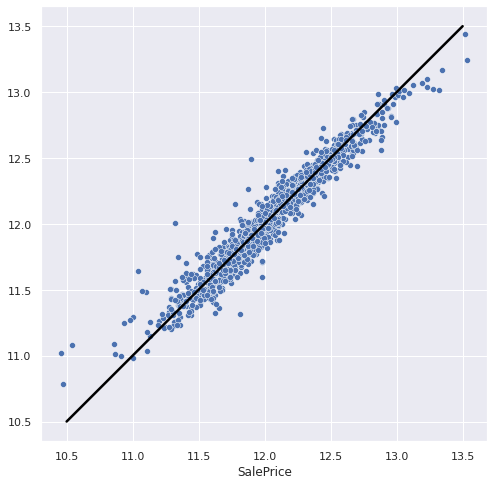

In [18]:
linear = LinearRegression()
linear.fit(train_data_trim,y)
y_hat = linear.predict(train_data_trim)
residuals = y - y_hat
y_and_yhat = pd.DataFrame(zip(y.values, y_hat, residuals), columns=['y', 'yhat', 'residuals'], index = train_data_trim.index)
print(r2_score(y,y_hat))

sns.scatterplot(y, y_hat)
sns.lineplot(np.linspace(10.5,13.5),np.linspace(10.5,13.5), color='black', linewidth=2.5)
plt.show()

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


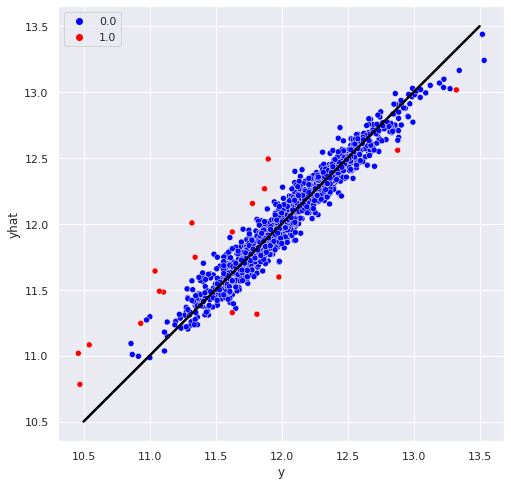

In [19]:
standard_red = (residuals - residuals.mean())/residuals.std()
outliers = train_data_trim[abs(standard_red)>3]
y_and_yhat.loc[y_and_yhat.index.isin(outliers.index),'Outlier'] = 1
y_and_yhat.loc[y_and_yhat['Outlier']!=1,'Outlier'] = 0

sns.scatterplot(data = y_and_yhat, x='y', y='yhat',hue ='Outlier', palette = ['blue','red'])
sns.lineplot(np.linspace(10.5,13.5),np.linspace(10.5,13.5), color='black', linewidth=2.5)
plt.show()

In [20]:
train_data_trim = train_data_trim.loc[y_and_yhat[y_and_yhat['Outlier'] == 0].index,:]
outlier_ind=outliers.index.tolist()
safe_ind = [num for num in y.index.tolist() if num not in outlier_ind]
y = y.loc[y.index.isin(safe_ind)]

**Step 5. Modelling**

In [21]:
kfolds = KFold(n_splits=10, shuffle=True, random_state=42)

alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

xgboost = XGBRegressor(n_estimators=3000, learning_rate=0.01, max_depth=4, min_child_weight=0, gamma=0, subsample=0.6,
                                     colsample_bytree=0.6, objective='reg:linear', nthread=-1, scale_pos_weight=1, seed=27,
                                     reg_alpha=0.00006)
gbr = GradientBoostingRegressor(n_estimators=2000, learning_rate=0.01, max_depth=6, max_features='sqrt', 
                                min_samples_leaf=30, min_samples_split=20, loss='huber', random_state =42)  
lightgbm = LGBMRegressor(objective='regression', num_leaves=10, learning_rate=0.01, n_estimators=2000, max_bin=500, 
                                       bagging_fraction=0.75, bagging_freq=5,  bagging_seed=7, feature_fraction=0.2,
                                       feature_fraction_seed=7, verbose=-1,
                                       )
ridge = RidgeCV(alphas=alphas_alt, cv=kfolds)
lasso = LassoCV(max_iter=1e7, alphas=alphas2, random_state=42, cv=kfolds)
elasticnet = ElasticNetCV(max_iter=1e7, alphas=e_alphas, cv=kfolds, l1_ratio=e_l1ratio) 
svr = SVR(C= 20, epsilon= 0.008, gamma=0.0003) 

X_train_full, X_valid_full, y_train, y_valid = train_test_split(train_data_trim, y, train_size = 0.7, test_size = 0.3, random_state = 1)

xgboost.fit(X_train_full, y_train)
y_xgb = xgboost.predict(X_valid_full)

gbr.fit(X_train_full, y_train)
y_gbr = gbr.predict(X_valid_full)

lightgbm.fit(X_train_full, y_train)
y_gbm = lightgbm.predict(X_valid_full)

ridge.fit(X_train_full, y_train) 
y_ridge = ridge.predict(X_valid_full)

lasso.fit(X_train_full, y_train)
y_lasso = lasso.predict(X_valid_full)

elasticnet.fit(X_train_full, y_train)
y_elasticnet = elasticnet.predict(X_valid_full)

svr.fit(X_train_full, y_train)
y_svr = svr.predict(X_valid_full)

print(mean_absolute_error(np.exp(y_valid),  np.exp(y_xgb)))
print(np.sqrt(mean_squared_error(np.exp(y_valid),  np.exp(y_xgb))))
print('-------------------------------')

print(mean_absolute_error(np.exp(y_valid),  np.exp(y_gbr)))
print(np.sqrt(mean_squared_error(np.exp(y_valid),  np.exp(y_gbr))))
print('-------------------------------')

print(mean_absolute_error(np.exp(y_valid),  np.exp(y_gbm)))
print(np.sqrt(mean_squared_error(np.exp(y_valid),  np.exp(y_gbm))))
print('-------------------------------')

print(mean_absolute_error(np.exp(y_valid), np.exp(y_ridge)))
print(np.sqrt(mean_squared_error(np.exp(y_valid), np.exp(y_ridge))))
print('-------------------------------')

print(mean_absolute_error(np.exp(y_valid), np.exp(y_lasso)))
print(np.sqrt(mean_squared_error(np.exp(y_valid), np.exp(y_lasso))))
print('-------------------------------')

print(mean_absolute_error(np.exp(y_valid), np.exp(y_elasticnet)))
print(np.sqrt(mean_squared_error(np.exp(y_valid), np.exp(y_elasticnet))))
print('-------------------------------')

print(mean_absolute_error(np.exp(y_valid), np.exp(y_svr)))
print(np.sqrt(mean_squared_error(np.exp(y_valid), np.exp(y_svr))))
print('-------------------------------')

[21:21:14] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
13505.038012234665
22694.853550335498
-------------------------------
13785.191981039721
24629.354422300265
-------------------------------
13459.935218108154
22990.396104776355
-------------------------------
13159.27297242134
20593.893639174607
-------------------------------
13197.995227805686
19819.222547104357
-------------------------------
13267.748904470978
20060.513228821852
-------------------------------
12899.2132644629
19728.398453538597
-------------------------------


In [22]:
y_pred = (0.15*y_gbr) + (0.1*y_xgb) + (0.15*y_gbm) + (0.15*y_ridge) + (0.15*y_lasso) + (0.15*y_elasticnet) + (0.15*y_svr)

print(mean_absolute_error(np.exp(y_valid),  np.exp(y_pred)))
print(np.sqrt(mean_squared_error(np.exp(y_valid),  np.exp(y_pred))))

12640.185783452976
20575.188470883404


**Step 7. Write data to an output file**

In [23]:
test_data_trim.index += 1
y_xgb_test = xgboost.predict(test_data_trim)
y_gbr_test = gbr.predict(test_data_trim)
y_gbm_test = lightgbm.predict(test_data_trim)
y_ridge_test = ridge.predict(test_data_trim)
y_lasso_test = lasso.predict(test_data_trim)
y_elasticnet_test = elasticnet.predict(test_data_trim)
y_svr_test = svr.predict(test_data_trim)

y_pred_test = (0.15*y_gbr_test) + (0.1*y_xgb_test) + (0.15*y_gbm_test) + (0.15*y_ridge_test) + (0.15*y_lasso_test) + (0.15*y_elasticnet_test) + (0.15*y_svr_test)
y_pred_test = np.exp(y_pred_test)

output = pd.DataFrame({'Id': test_data_trim.index.tolist(), 'SalePrice': y_pred_test.tolist()})
output.to_csv('submission.csv', index=False)